# Anuario de Aforos: seleccionar estaciones
***

***Autor:** Jesús Casado Rodríguez*<br>
***Fecha:** 12-08-2023*<br>

**Introducción:**

**Por hacer**:
* [x] Aplicar el filtro por área de cuenca.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import yaml
import cartopy.crs as ccrs
import cartopy.feature as cf
from tqdm.notebook import tqdm
from pathlib import Path

from anuario_aforos import *

## Configuración

In [2]:
with open("../conf/config.yml", "r", encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

# ruta donde se ubican los datos del Anurio de Aforos
path_in = Path(cfg['rutas']['anuario_aforos'])

# inicio y fin del periodo de estudio
start = cfg['periodo'].get('inicio', None)
end = cfg['periodo'].get('final', None)
start, end = [pd.to_datetime(i) for i in [start, end]]

# tamaño mínimo y máximo de la cuenca
area_min = cfg['area'].get('min', 100) # km²
area_max = cfg['area'].get('max', None) # km²

# disponibilidad mínima de datos durante el periodo de estudio (tanto por uno)
disponibilidad = cfg['seleccion'].get('disponibilidad', .9)
min_años = cfg['seleccion'].get('n_años', .9)

In [3]:
path_out = Path('../data/anuario_aforos/')
path_GIS = path_out / 'GIS/'
path_plots = path_out / 'plots/'
for path in [path_out, path_GIS, path_plots]:
    if path.exists() is False:
        path.mkdir()

## Estaciones

In [4]:
cuencas = [dir for dir in os.listdir(path_in) if os.path.isdir(os.path.join(path_in, dir))]
if 'estaciones' in locals():
    del estaciones
for cuenca in tqdm(cuencas):
    stns = extraer_estaciones(path_in / f'{cuenca}/estaf.csv',
                              min_area=area_min, max_area=area_max, years=min_años, epsg=4326)
    stns['cuenca'] = cuenca
    if 'estaciones' in locals():
        estaciones = pd.concat((estaciones, stns))
    else:
        estaciones = stns
    print('nº de estaciones en el {0}:\t\t{1}'.format(cuenca.capitalize(), stns.shape[0]))

  0%|          | 0/10 [00:00<?, ?it/s]

nº de estaciones en el Cantabrico:		57
nº de estaciones en el Duero:		169
nº de estaciones en el Ebro:		220
nº de estaciones en el Galicia:		37
nº de estaciones en el Guadalquivir:		95
nº de estaciones en el Guadiana:		117
nº de estaciones en el Jucar:		95
nº de estaciones en el Minho:		62
nº de estaciones en el Segura:		59
nº de estaciones en el Tajo:		163


nº total de estaciones:		1074
nº de estaciones en servicio:	704


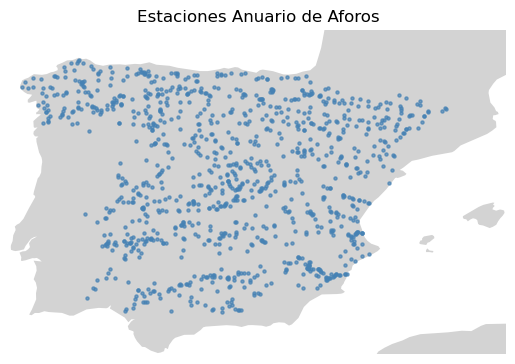

In [5]:
# plot estaciones
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj})
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='lightgray'), zorder=0)
ax.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
ax.scatter(estaciones.geometry.x, estaciones.geometry.y, c='steelblue', s=5, alpha=.7, label='Anuario')
ax.set_title('Estaciones Anuario de Aforos')
ax.axis('off');

plt.savefig(path_plots / 'estaciones.jpg', dpi=300, bbox_inches='tight');

print('nº total de estaciones:\t\t{0}'.format(estaciones.shape[0]))
print('nº de estaciones en servicio:\t{0}'.format(estaciones.loc[estaciones.serv == 1].shape[0]))

In [6]:
# sns.histplot(estaciones.naa, binwidth=1);

In [7]:
# sns.histplot(estaciones.suprest);
# plt.xscale('log')

## Embalses

In [8]:
if 'embalses' in locals():
    del embalses
for cuenca in tqdm(cuencas):
    res = extraer_embalses(path_in / f'{cuenca}/embalse.csv', epsg=4326)
    res['cuenca'] = cuenca
    if 'embalses' in locals():
        embalses = pd.concat((embalses, res))
    else:
        embalses = res
    print('nº de embalses en el {0}:\t\t{1}'.format(cuenca.capitalize(), res.shape[0]))
    del res

  0%|          | 0/10 [00:00<?, ?it/s]

nº de embalses en el Cantabrico:		22
nº de embalses en el Duero:		31
nº de embalses en el Ebro:		95
nº de embalses en el Galicia:		8
nº de embalses en el Guadalquivir:		62
nº de embalses en el Guadiana:		31
nº de embalses en el Jucar:		35
nº de embalses en el Minho:		35
nº de embalses en el Segura:		18
nº de embalses en el Tajo:		57


nº total de embalses:		394
nº de embalses en servicio:	363


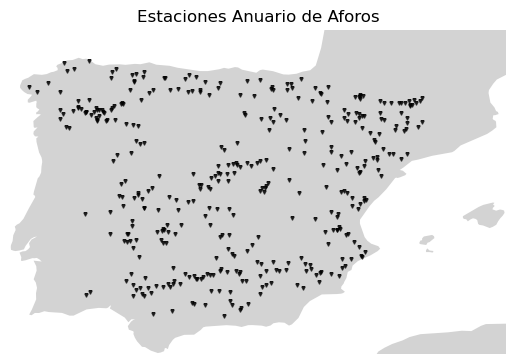

In [9]:
# plot subcuencas
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj})
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='lightgray'), zorder=0)
ax.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
ax.scatter(embalses.geometry.x, embalses.geometry.y, c='k', marker='v', s=5, alpha=.7, label='Anuario')
ax.set_title('Estaciones Anuario de Aforos')
ax.axis('off');

plt.savefig(f'{path_plots}embalses.jpg', dpi=300, bbox_inches='tight');

print('nº total de embalses:\t\t{0}'.format(embalses.shape[0]))
print('nº de embalses en servicio:\t{0}'.format(embalses.loc[embalses.serv == 1].shape[0]))

## Caudal 

In [10]:
if 'caudal' in locals():
    del caudal
for cuenca in tqdm(cuencas):
    ids = estaciones[estaciones.cuenca == cuenca].index.to_list()
    q = extraer_caudal(path_in / f'{cuenca}/afliq.csv', 
                       indroea=ids, start=start, end=end)
    if 'caudal' in locals():
        caudal = pd.concat((caudal, q), axis=1)
    else:
        caudal = q
    print('nº de estaciones en las series de caudal del {0}:\t\t{1} ({2})'.format(cuenca.capitalize(),
                                                                                  q.shape[1],
                                                                                  len(ids)))

print('nº total de estaciones con serie de caudal:\t\t{0} ({1})'.format(caudal.shape[1], estaciones.shape[0]))

  0%|          | 0/10 [00:00<?, ?it/s]

nº de estaciones en las series de caudal del Cantabrico:		45 (57)
nº de estaciones en las series de caudal del Duero:		160 (169)
nº de estaciones en las series de caudal del Ebro:		196 (220)
nº de estaciones en las series de caudal del Galicia:		34 (37)
nº de estaciones en las series de caudal del Guadalquivir:		75 (95)
nº de estaciones en las series de caudal del Guadiana:		82 (117)
nº de estaciones en las series de caudal del Jucar:		48 (95)
nº de estaciones en las series de caudal del Minho:		50 (62)
nº de estaciones en las series de caudal del Segura:		39 (59)
nº de estaciones en las series de caudal del Tajo:		105 (163)
nº total de estaciones con serie de caudal:		834 (1074)


In [11]:
# añadir un campo booleano en 'estaciones' si tiene o no datos de caudal
estaciones['caudal'] = 0
estaciones.loc[caudal.columns, 'caudal'] = 1

In [12]:
# definir el mejor periodo de estudio de cada estación
estaciones[['inicio', 'fin']] = periodo_estudio(caudal, disponibilidad, min_años)

# estaciones con el mínimo de nº de años
mask_años = ~estaciones.inicio.isnull()
print('nº total de estaciones con {0} años de caudal:\t\t{1}'.format(min_años, mask_años.sum()))#caudal.shape[1]))

nº total de estaciones con 8 años de caudal:		606


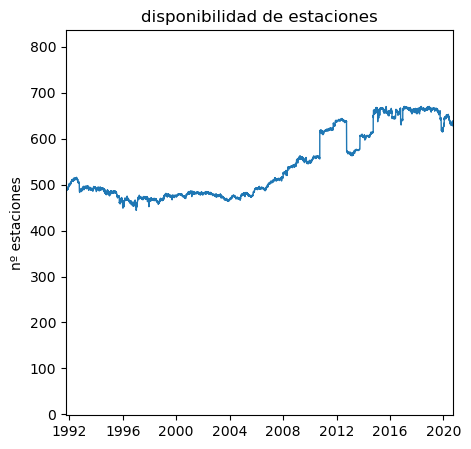

In [13]:
# gráfico de la disponibilidad de estaciones
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(caudal.shape[1] - caudal.isnull().sum(axis=1), lw=1)
ax.set(ylim=(-2, caudal.shape[1] + 2), xlim=(start, end), ylabel='nº estaciones')
ax.axhline(estaciones.shape[0], c='k', lw=.5)
ax.set_title('disponibilidad de estaciones');

plt.savefig(path_plots / 'disponibilidad.jpg', dpi=300, bbox_inches='tight');

In [26]:
plt.switch_backend('Agg')
for stn in tqdm(estaciones[mask_años].index):

    # inicio y fin de la serie de esta estación
    inicio = datetime(int(estaciones.loc[stn, 'inicio']), 1, 1)
    fin = datetime(int(estaciones.loc[stn, 'fin']), 1, 1)

    # hidrogromas
    file = path_out / '{0}/plots/{1:04}.jpg'.format(estaciones.loc[stn, 'cuenca'], stn)
    title = '{0} - {1} ({2} km2)'.format(stn, *estaciones.loc[stn, ['lugar', 'suprest']])
    plot_caudal(caudal.loc[inicio:fin, stn], title=title, save=file)

  0%|          | 0/600 [00:00<?, ?it/s]

C:\GitHub\TFM\notebook\anuario_aforos.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=kwargs.get('figsize', (16, 4)))


In [14]:
# estaciones a eliminar porque la serie está alterada por embalses
# las estaciones comentadas son etaciones dudosas
eliminar = {'CANTABRICO': ['1164','1175', '1186', '1196', '1207', '1215', '1237',
                           '1264', '1274', '1276', '1294', '1335', '1358', '1359',
                           '1425'],
            'DUERO': ['2001', '2002', '2004', '2010', '2011', '2018', '2019', '2020',
                      '2021', '2023', '2024', '2032', '2040', '2042', '2044', '2052', '2066',
                      '2073', '2075', '2078', '2084', '2087', '2088', '2091', '2094',
                      '2099', '2102', '2103', '2108', '2109', '2111', '2112', '2124', '2129',
                      '2133', '2134', '2135', '2137', '2140', '2148', '2149', '2161',
                      '2162', '2718', '2719'],
            #'2041', '2050', '2061', '2062', '2074'
            'EBRO': ['9001', '9005', '9007', '9008', '9010', '9012', '9013', '9014',
                     '9015', '9017', '9022', '9024', '9025', '9026', '9027', '9031',
                     '9032', '9034', '9035', '9036', '9042', '9047', '9048', '9049',
                     '9055', '9056', '9057', '9058', '9059', '9060', '9065', '9066', '9076', '9083',
                     '9084', '9094', '9096', '9097', '9099', '9100', '9101', '9105',
                     '9106', '9111', '9115', '9118', '9122', '9123', '9124', '9125',
                     '9126', '9127', '9137', '9142', '9145', '9147', '9155', '9161',
                     '9163', '9168', '9174', '9176', '9185', '9186', '9190', '9191', '9192',
                     '9193', '9201', '9209', '9216', '9225', '9229', '9230', '9231', '9250', '9250', '9251',
                     '9258', '9260', '9264', '9266', '9273', '9277', '9278', '9290',
                     '9292', '9307', '9315', '9319'],
            #, '9153', '9291', '9317'
            'GALICIA': ['1455', '1514', '1519', '1550', '1564'],
            'GUADALQUIVIR': ['5001', '5004', '5014', '5019', '5020', '5024', '5025',
                             '5027', '5041', '5042', '5048', '5081', '5082', '5084', '5090',
                             '5095', '5127', '5144'],
             # '5045', '5050', '5138', '5140', ''
            'GUADIANA': ['4004', '4009', '4013', '4030', '4105', '4201', '4202', '4203', '4209', '4904'],
            # , ''
            'JUCAR': ['8005', '8015', '8022', '8025', '8032', '8036', '8042', '8071', '8074', '8089', '8093', '8096',
                      '8107', '8112', '8119', '8129', '8130', '8137', '8138', '8139',
                      '8144', '8145', '8147'],
                      #, '8028', '8032', '8060', '8104', '8120'
            'MINHO': ['1631', '1639', '1640', '1642', '1719', '1831'],
            'SEGURA': ['7001', '7003', '7004', '7006', '7013', '7016', '7018', '7029', '7030', '7055',
                       '7057', '7062', '7063', '7064', '7124', '7137', '7164', '7167', '7628'],
            # , '7112', '7117', '7121', '7165', ''
            'TAJO': ['3003', '3031', '3041', '3054', '3060', '3061', '3063', '3067', '3070', '3080', '3082',
                     '3147', '3149', '3153', '3158', '3162', '3164', '3172', '3173', '3177', '3183',
                     '3187', '3188', '3230', '3232', '3237', '3238', '3240', '3243', '3248',
                     '3254', '3258', '3259', '3270', '3271', '3273', '3281', '3904',
                      '3940'],
            #'3012', '3014', '3062, '3169', '3174', '3175', '3220', '3233', 
            #'3250', '3251', '3253', '3255', '3256', '3268', '3276', '3278', '3279', ''
            }

In [15]:
# # estaciones a eliminar porque la serie está alterada por embalses
# eliminar = {'ebro': [9008, 9010, 9014, 9025, 9026, 9034, 9035, 9036, 9039, 9042,
#                      9055, 9056, 9057, 9058, 9083, 9084, 9096, 9097, 9099, 9101,
#                      9105, 9106, 9109, 9110, 9113, 9118, 9122, 9124, 9125, 9126,
#                      9142, 9145, 9147, 9168, 9176, 9184, 9192, 9216],
#             'cantabrico': [],
#             'duero': [2002, 2004, 2010, 2011, 2019, 2020, 2022, 2024, 2032, 2040,
#                       2041, 2044, 2047, 2049, 2056, 2073, 2075, 2077, 2078,
#                       2087, 2102, 2103, 2107, 2108, 2019, 2124, 2129, 2134],
#             'tajo': [3003, 3012, 3030, 3041, 3045, 3052, 3060, 3061, 3062, 3067,
#                      3070, 3080, 3082, 3144, 3147, 3153, 3158, 3159, 3169, 3186,
#                      3213, 3230, 3232, 3238, 3254, 3255, 3259, 3266, 3268, 3940],
#             'minho': [],
#             'guadalquivir': [5001, 5020, 5039, 5041, 5077, 5090],
#             'segura': [7003, 7006, 7013, 7016, 7018, 7030, 7063],
#             'jucar': [8005, 8015, 8018, 8025, 8027, 8074, 8093, 8096, 8099, 8107,
#                       8112, 8119, 8129, 8139, 8140, 8141, 8147, ],
#             'galicia': []}

# estaciones_.drop(eliminar[catchment], axis=0, inplace=True)

# print(f'{estaciones_.shape[0]} estaciones fueron seleccionadas')

In [16]:
# crear campo booleano con las estaciones seleccionadas
estaciones['sel'] = (~estaciones.inicio.isnull()).astype(int)
for cuenca in cuencas:
    estaciones.loc[eliminar[cuenca], 'sel'] = 0

print('nº de estaciones seleccionadas:\t{0}'.format((estaciones.sel == 1).sum()))

nº de estaciones seleccionadas:	337


In [17]:
# estaciones a eliminar porque hay otra estación cercana
eliminar2 = {'CANTABRICO': ['1303'],
            'DUERO': ['2076', '2070', '2068', '2117', '2710', '2123', '2097', '2085', ],
            'EBRO': ['9153', '9046', '9091', '9043', '9268', '9018', '9313', '9253', '9329', '9050'],
            'GALICIA': ['1440', '1483'],
            'GUADALQUIVIR': ['5076', '5128', '5080'],
            'GUADIANA': [],
            'JUCAR': ['8030'],
            'MINHO': ['1644', '1645','1626', '1625', '1628', '1621', '1607', '1608', '1617', '1754',
                      '1727', '1722', '1724'],
            'SEGURA': ['7165', '7117', '7129'],
            'TAJO': ['3194', '3102', '3159'],
            }

In [18]:
for cuenca in cuencas:
    estaciones.loc[eliminar2[cuenca], 'sel'] = 0

print('nº de estaciones seleccionadas:\t{0}'.format((estaciones.sel == 1).sum()))

nº de estaciones seleccionadas:	293


## Exportar resultados

In [19]:
# exportar todas las estaciones juntas
estaciones.to_file(path_GIS / 'estaciones.shp', driver='ESRI Shapefile', index=True)

In [20]:
# exportar las series de caudal
caudal.to_parquet(path_out / 'caudal.parquet')

In [21]:
# exportar todos los embalses juntos
embalses.rename(columns={'nom_embalse': 'nombre'}, inplace=True)
embalses.to_file(path_GIS / 'embalses.shp', driver='ESRI Shapefile', index=True)